# Playlist Data Analysis

This notebook analyzes the playlists defined in `my_data.jsonl`. It fetches metadata using `yt-dlp` to calculate statistics like song counts and durations per genre.

In [1]:
import json
import os
import pandas as pd
import yt_dlp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_theme(style="whitegrid")

In [2]:
def fetch_playlist_metadata(jsonl_path):
    data = []
    
    # Options to fetch metadata without downloading
    ydl_opts = {
        'extract_flat': True,  # Don't download video, just get metadata
        'quiet': True,
        'ignoreerrors': True,
        'noprogress': True,
        'logger': None # Suppress internal yt-dlp logs
    }

    with open(jsonl_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            
            entry = json.loads(line)
            genre = entry.get('genre')
            link = entry.get('link')
            
            if not genre or not link:
                continue
                
            link = link.replace('\\', '') # Clean link
            print(f"Fetching metadata for genre: {genre}...")
            
            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                try:
                    info = ydl.extract_info(link, download=False)
                    if 'entries' in info:
                        for video in info['entries']:
                            if video:
                                data.append({
                                    'genre': genre,
                                    'title': video.get('title'),
                                    'duration': video.get('duration', 0), # Duration in seconds
                                    'id': video.get('id')
                                })
                except Exception as e:
                    print(f"Error fetching {link}: {e}")
                    
    return pd.DataFrame(data)

# Load data
jsonl_file = 'my_data.jsonl'
df = fetch_playlist_metadata(jsonl_file)
print(f"Loaded {len(df)} songs.")
df.head()

Fetching metadata for genre: newari...
Fetching metadata for genre: bhojpuri...
Fetching metadata for genre: tamang selo...
Loaded 279 songs.


,genre,title,duration,id
0,newari,Gaale Kobaala | Official Music Video | Roj Man...,450.0,VhJHnFbmHYk
1,newari,Anti Pana || New Newari Song 2017 /2074 Nepal...,237.0,hu_jQMbi5Ug
2,newari,Ekaya Hami - Asan Twa | donob sessions,403.0,2HTRkmBVE6w
3,newari,Kaula kachala ashoj kartik | Official Music Vi...,269.0,IOWPwUi6B_U
4,newari,Ujan Shakya - LUMANTI (Official Music Video),309.0,zTRC1ZBIpVk


## 1. Songs per Genre

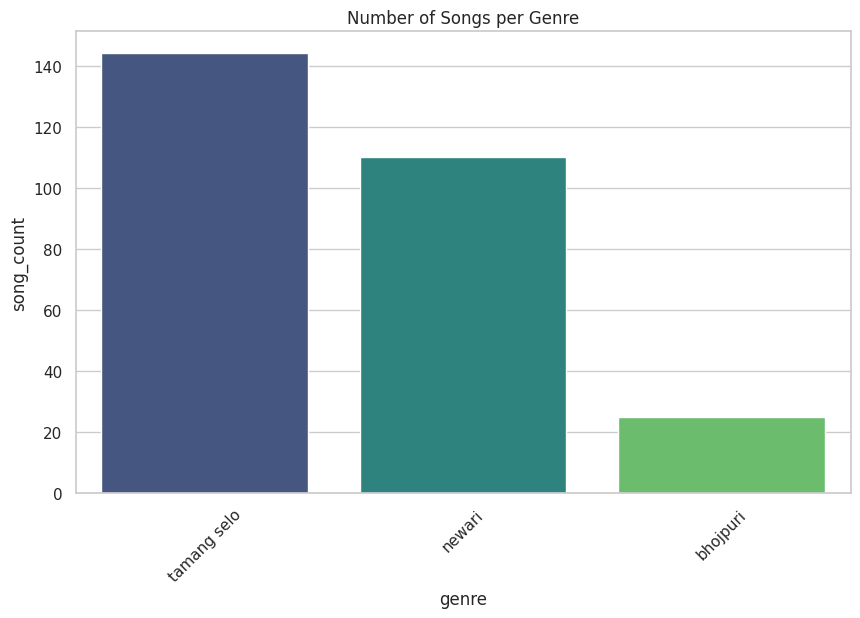

         genre  song_count
0  tamang selo         144
1       newari         110
2     bhojpuri          25


In [3]:
genre_counts = df['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'song_count']

plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts, x='genre', y='song_count', palette='viridis')
plt.title('Number of Songs per Genre')
plt.xticks(rotation=45)
plt.show()

print(genre_counts)

## 2. Duration Analysis
Calculating total and average duration per genre.

In [4]:
# Convert duration to minutes for easier reading
df['duration_min'] = df['duration'] / 60

duration_stats = df.groupby('genre')['duration_min'].agg(['sum', 'mean', 'count']).reset_index()
duration_stats.columns = ['genre', 'total_duration_min', 'avg_duration_min', 'song_count']
duration_stats['total_duration_hours'] = duration_stats['total_duration_min'] / 60

print(duration_stats[['genre', 'song_count', 'total_duration_hours', 'avg_duration_min']])

         genre  song_count  total_duration_hours  avg_duration_min
0     bhojpuri          25              1.522778          3.654667
1       newari         109              9.256667          5.095413
2  tamang selo         144             13.925556          5.802315


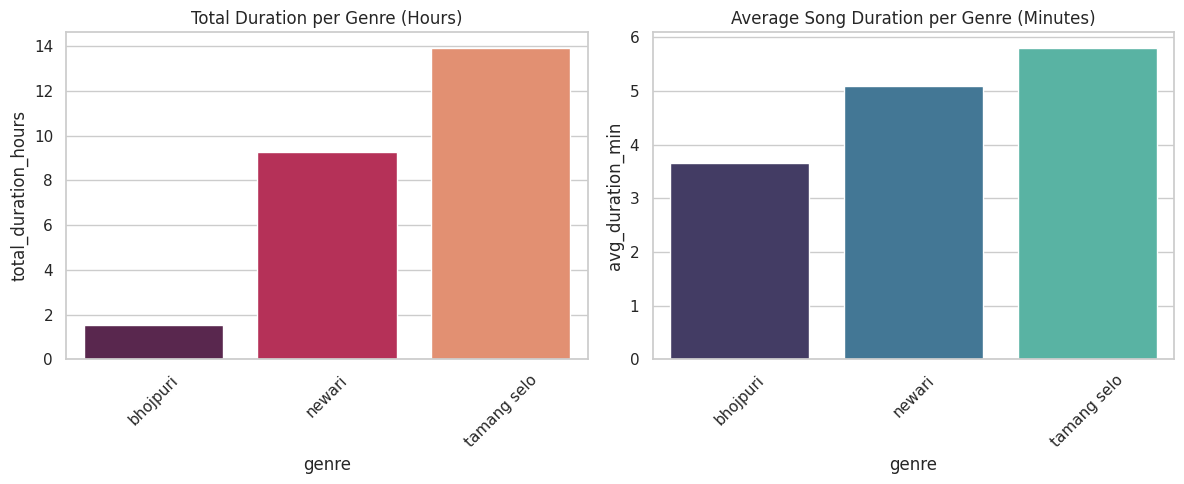

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=duration_stats, x='genre', y='total_duration_hours', palette='rocket')
plt.title('Total Duration per Genre (Hours)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=duration_stats, x='genre', y='avg_duration_min', palette='mako')
plt.title('Average Song Duration per Genre (Minutes)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3. Distribution of Song Lengths

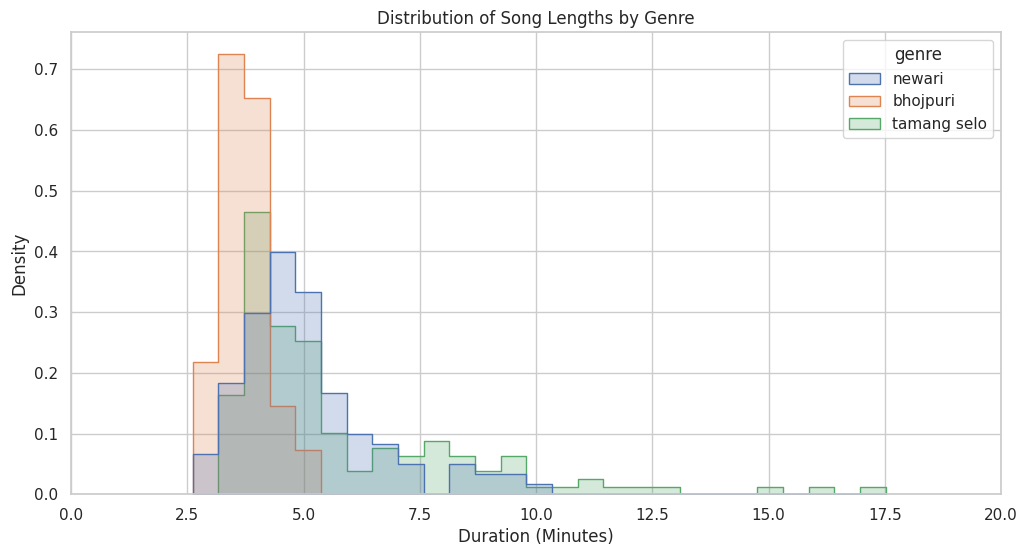

In [6]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='duration_min', hue='genre', element='step', stat='density', common_norm=False)
plt.title('Distribution of Song Lengths by Genre')
plt.xlabel('Duration (Minutes)')
plt.xlim(0, 20) # Limiting to 20 mins to avoid outliers skewing the plot
plt.show()